In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from models.iav_flap_anomaly_detection import make_data, plot_data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Installation instructions

To create the data set and show the example plots, you need to install

* matplotlib
* numpy
* sklearn

and you're good to go!

# The problem

Below is your data. We have a system that produces data that normally looks like the left picture. However, there is a special kind of problem that occurs that makes the data shift and flip. Usually, nobody has the time to look at the data and label it - we only have data of which we know that it is probably ok and serves as your training data. Can you tell the problematic data apart anyway?

In [3]:
X_train, X_test, test_ground_truth = make_data()

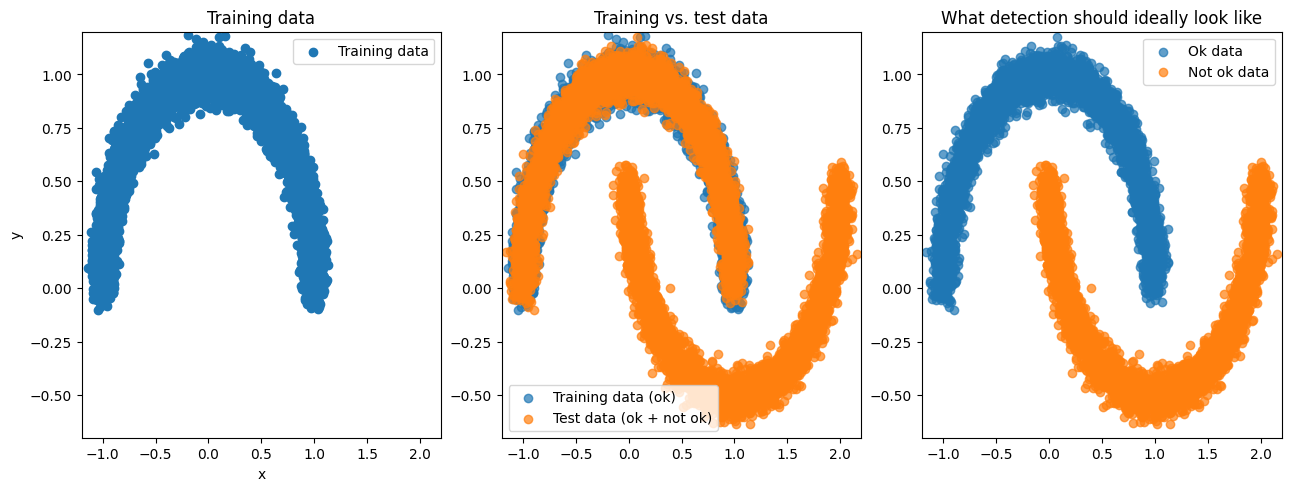

In [4]:
plot_data(X_train, X_test, test_ground_truth)

## Your task

1. Which kind of anomaly detection are you performing?

    1) Supervised
    2) Semi-supervised
    3) Unsupervised

2. Pick a suitable model, for example from scikit-learn (if you know other anomaly detection packages, we're fine with that too)
3. Train it on the training data, and ONLY the training data. Don't cheat by incorporating knowledge about the test set ;-)
4. Try to tell which points of the data are not ok (i.e. don't look like the training data)
5. How good is your model?

## Your solution

Do not hesitate to play around with several different models. Don't worry too much about accuracy - if you're at about 80%, that's fine. We told you the problem is hard ;-) ...`

In [5]:
display(X_train)
display(X_train.shape)
display(X_test.shape)

array([[-1.0899257 , -0.05305947],
       [-0.30413688,  0.94969711],
       [-0.1506498 ,  0.98350863],
       ...,
       [ 0.54148866,  0.86963401],
       [ 0.8848261 ,  0.55049183],
       [-0.84523706,  0.49430933]])

(10000, 2)

(10000, 2)

In [6]:
import numpy as np

# Suppose y_train contains +1 for normal points and -1 for outliers
fraction_outliers_test = np.mean(test_ground_truth == -1)

#print(f"Fraction of outliers in training set: {fraction_outliers_train:.2%}")
print(f"Fraction of outliers in test set: {fraction_outliers_test:.2%}")

Fraction of outliers in test set: 50.00%


one class svm

Evaluation Metrics:
accuracy: 0.743
precision: 0.663
recall: 0.987
f1_score: 0.794


/Users/AnanyaPal1/Documents/test_task/Anomaly-Detection/models/one_class_svm.py:140: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contourf(xx, yy, Z, levels=[Z.min(), 0], color = 'orange', alpha=0.3)


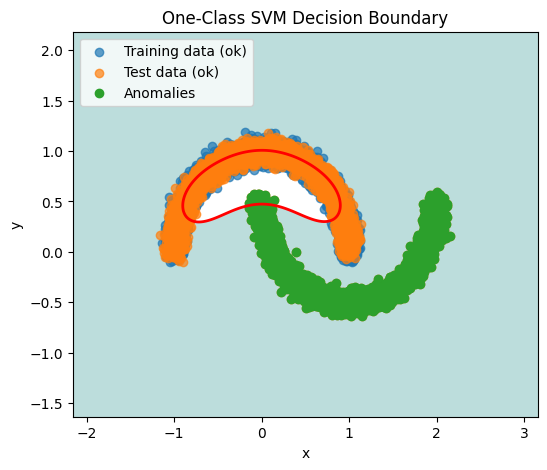

In [15]:
from models.one_class_svm import OneClassSVMModel

model = OneClassSVMModel(kernel='rbf', nu=0.5, gamma='scale')

# Train the model on training data
model.fit(X_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model using multiple metrics
metrics = model.evaluate(X_test, test_ground_truth)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Suppose you have X_train, X_test, and test_ground_truth defined.
# And you have already trained your model and obtained predictions.

# Determine outlier indices based on ground truth, if desired:
outlier_mask = (test_ground_truth == -1)

# Call the plotting method on your best model (or an instance of IsolationForestModel)
model.plot_decision_boundary(X_train, X_test=X_test, X_outliers=X_test[outlier_mask])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
 

Best parameters found: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.05}
Evaluation Metrics (after tuning):
accuracy: 0.570
precision: 0.613
recall: 0.376
f1_score: 0.466


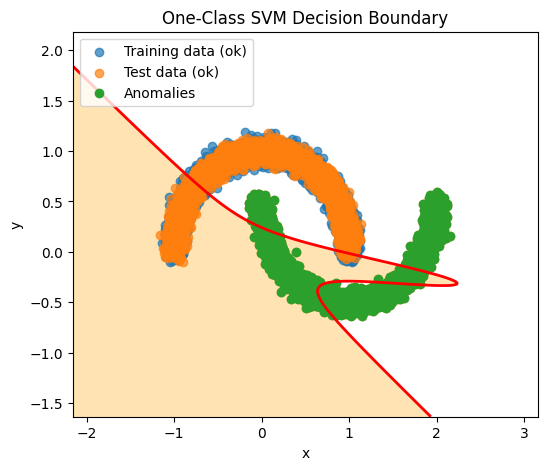

In [8]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import numpy as np
from models.one_class_svm import OneClassSVMWrapper

# Define a custom scoring function that uses the estimator's predict method
def custom_scoring(estimator, X, y, **kwargs):
    y_pred = estimator.predict(X)
    return f1_score(y, y_pred, pos_label=-1)

# Instead of a lambda, define a wrapper that explicitly accepts (estimator, X, y, **kwargs)
def scorer_wrapper(estimator, X, y, **kwargs):
    return custom_scoring(estimator, X, y, **kwargs)

scorer = make_scorer(scorer_wrapper, greater_is_better=True)

param_grid = {
    "kernel": ['poly'],
    "degree" : [2, 3, 4],           
    "nu": [0.05, 0.1, 0.2, 0.3, 0.5],
    "gamma": ['auto']
}

# Combine X_train and X_test into a single dataset:
# - X_train contains only normal data (label 1)
# - X_test contains a mix (with test_ground_truth providing labels: 1 for normal, -1 for anomaly)
X_all = np.vstack([X_train, X_test])
y_all = np.hstack([np.ones(len(X_train)), test_ground_truth])

# Create a PredefinedSplit to ensure that only X_train is used for training and X_test for validation.
# In the test_fold array, samples from X_train are marked with -1 (training) and X_test with 0 (validation).
test_fold = np.concatenate((np.full(len(X_train), -1), np.zeros(len(X_test))))
ps = PredefinedSplit(test_fold=test_fold)

# Initialize the model wrapper with default parameters
model_wrapper = OneClassSVMWrapper(kernel='poly', nu=0.5, gamma='auto')

# Run GridSearchCV with our predefined split
grid_search = GridSearchCV(model_wrapper, param_grid, scoring=scorer, cv=ps)
grid_search.fit(X_all, y_all)

print("Best parameters found:", grid_search.best_params_)

# Use the best estimator for predictions and evaluation on X_test only
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
metrics = best_model.evaluate(X_test, test_ground_truth)
print("Evaluation Metrics (after tuning):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

# Visualize the decision boundary (for 2D data)
outlier_mask = test_ground_truth == -1
best_model.plot_decision_boundary(X_train, X_test=X_test, X_outliers=X_test[outlier_mask])


LocalOutlierFactor  - unsupervised
Density-based method that measures the local deviation of a given data point with respect to its neighbors.
Points with a substantially lower density than their neighbors are considered outliers.

IsolationForest  - 
Based on random forests but specifically tailored for outlier detection.
Isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The idea is that anomalies are easier to isolate compared to normal points.

{'accuracy': 0.9903, 'precision': 0.9809691975671964, 'recall': 1.0, 'f1_score': 0.9903931860948797}


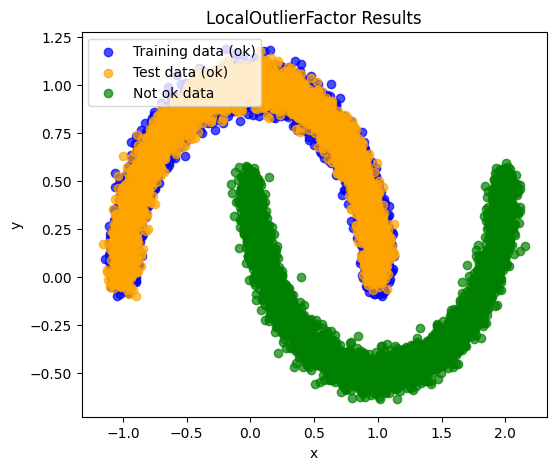

In [9]:
from models.local_outlier_factor_model import LocalOutlierFactorModel
from models.local_outlier_factor_model import *

#  Instantiate the model
lof_model =LocalOutlierFactorModel(
    n_neighbors=40,
    contamination='auto',  # or a float like 0.1
    novelty=True           # predict on X_test
)

#  Fit the model on your training data
lof_model.fit(X_train)

# Predict anomalies on test data (only valid if novelty=True).
#    If novelty=False, you might do:
#    y_pred = lof_model.model.fit_predict(X_test)
y_pred = lof_model.predict(X_test)

# Evaluate on ground truth values
metrics = lof_model.evaluate(X_test, test_ground_truth)
print(metrics)

# Suppose you have:
# X_train: used to fit LOF (mostly or all normal)
# X_test: new test data
# test_ground_truth: array of +1 (ok) or -1 (not ok) for each point in X_test

outlier_mask = (test_ground_truth == -1)
X_test_ok = X_test[~outlier_mask]
X_test_not_ok = X_test[outlier_mask]

# Now call your LOF model's plot function
lof_model.plot_lof_predictions(
    X_train=X_train,
    X_test=X_test_ok,
    X_outliers=X_test_not_ok,
    title="LocalOutlierFactor Results"
)

In [10]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from models.local_outlier_factor_model import LocalOutlierFactorModel

# Assume:
# X_train: array of shape (10000, 2) -- training data (assumed normal, no labels)
# X_test: array of shape (10000, 2) -- test data (contains both ok and not ok)
# test_ground_truth: array of shape (10000,) with labels +1 (ok) and -1 (anomaly)

# Set up Repeated Stratified K-Fold on X_test (since it has ground truth labels)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# For each fold, use the training part of X_test (only normal points) combined with X_train for fitting.
fold_no = 1
for train_idx, val_idx in rskf.split(X_test, test_ground_truth):
    # Training portion from test set and its labels
    X_test_train, y_test_train = X_test[train_idx], test_ground_truth[train_idx]
    # Validation portion from test set and its labels
    X_val, y_val = X_test[val_idx], test_ground_truth[val_idx]
    
    # From the test training split, only select points labeled as normal (+1)
    normal_mask = (y_test_train == 1)
    X_test_train_normal = X_test_train[normal_mask]
    
    # Combine your fixed X_train (all normal) with the normal examples from the current test training fold
    X_train_combined = np.vstack([X_train, X_test_train_normal])
    
    # Instantiate and fit LOF on the combined normal data
    lof_model_cv = LocalOutlierFactorModel(
        n_neighbors=40,
        contamination='auto',
        novelty=True
    )
    lof_model_cv.fit(X_train_combined)
    
    # Predict on the validation fold (which contains both ok and anomalies)
    y_pred = lof_model_cv.predict(X_val)
    
    # Evaluate metrics using anomalies (-1) as the positive class.
    # Note: Adjust pos_label if needed depending on your metric implementation.
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, pos_label=-1)
    rec = recall_score(y_val, y_pred, pos_label=-1)
    f1 = f1_score(y_val, y_pred, pos_label=-1)
    
    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)
    
    print(f"Fold {fold_no} -- Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    fold_no += 1

# Report the overall mean and standard deviation across folds
print("\nCross-Validation Results (using combined normal training):")
print(f"Accuracy:  {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
print(f"Recall:    {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
print(f"F1 Score:  {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")


Fold 1 -- Accuracy: 0.9930, Precision: 0.9862, Recall: 1.0000, F1 Score: 0.9930
Fold 2 -- Accuracy: 0.9890, Precision: 0.9785, Recall: 1.0000, F1 Score: 0.9891
Fold 3 -- Accuracy: 0.9915, Precision: 0.9833, Recall: 1.0000, F1 Score: 0.9916
Fold 4 -- Accuracy: 0.9920, Precision: 0.9843, Recall: 1.0000, F1 Score: 0.9921
Fold 5 -- Accuracy: 0.9925, Precision: 0.9852, Recall: 1.0000, F1 Score: 0.9926
Fold 6 -- Accuracy: 0.9925, Precision: 0.9852, Recall: 1.0000, F1 Score: 0.9926
Fold 7 -- Accuracy: 0.9930, Precision: 0.9862, Recall: 1.0000, F1 Score: 0.9930
Fold 8 -- Accuracy: 0.9905, Precision: 0.9814, Recall: 1.0000, F1 Score: 0.9906
Fold 9 -- Accuracy: 0.9935, Precision: 0.9872, Recall: 1.0000, F1 Score: 0.9935
Fold 10 -- Accuracy: 0.9885, Precision: 0.9775, Recall: 1.0000, F1 Score: 0.9886
Fold 11 -- Accuracy: 0.9910, Precision: 0.9823, Recall: 1.0000, F1 Score: 0.9911
Fold 12 -- Accuracy: 0.9870, Precision: 0.9747, Recall: 1.0000, F1 Score: 0.9872
Fold 13 -- Accuracy: 0.9925, Precisio

It may seem contradictory to have high quantitative metrics (accuracy ~99%, F1 ~99%) yet still observe misclassifications in the scatter plot. Here’s why this can happen:

1. LOF has no global decision boundary.  
Unlike models such as One-Class SVM, the Local Outlier Factor (LOF) is a local density-based method. It compares each point’s density to that of its neighbors. There is no single global boundary or curve to visualize. Instead, the decision of whether a point is an inlier or an outlier depends on the density of its surrounding region relative to its neighbors. This is why you don’t see an explicit decision boundary in the scatter plot.

2. Possible overlap of “anomalies” with inlier regions.  
In the scatter plot, some points labeled as anomalies (often shown in orange) may appear in what looks like a normal (blue) region. This can occur if LOF’s local density measure for those points is not substantially different from that of their neighbors. For example, if the anomalies are not sufficiently different from the normal data points on a local level, or if the data is highly imbalanced so that the anomalous points are overwhelmed by many normal ones, LOF may still label them as inliers.

3. Training versus testing with LOF.  
When LOF is used with the default setting (novelty=False), it is typically applied to the same dataset it was fit on using a method like fit_predict(X). Using LOF on truly new data can be misleading because the standard approach does not support out-of-sample predictions. In scenarios where you train on one dataset (X_train) and then predict on another (X_test) with novelty=False, scikit-learn might either disallow it or re-fit on the new data behind the scenes. This can lead to artificially high metrics or unexpected behavior since the model is effectively relearning the local densities in each subset. If you set novelty=True, LOF switches to novelty detection mode and allows predictions on new data, but the local densities from training may not perfectly transfer, sometimes yielding inflated metrics if the test set isn’t truly novel.

4. Contamination and imbalance.  
LOF uses a contamination parameter to estimate the proportion of outliers in the data. If this parameter is set too low compared to the actual number of outliers, LOF will still classify most points as inliers. Visually, many “not ok” (anomalous) points may appear among the normal region, while quantitatively, the overall metrics can remain very high because the vast majority of points are correctly classified as normal.

5. Why the metrics might still be high.  
There are a few reasons for high metrics despite some misclassifications. First, if only a small fraction of your test set is labeled as anomalous, a model that predicts most points as normal can still achieve high accuracy and decent precision and recall. Second, if you used LOF in outlier-detection mode (novelty=False) and evaluated on the same or very similar data, the model might have effectively “memorized” the local densities, which boosts the metrics. Third, even when some anomalies are misclassified, their local densities might be very similar to their neighbors, so the overall performance metrics remain high.

6. No single “best” visualization.  
Because LOF operates on a local scale, you won’t see a neat decision boundary like you might with an SVM or an elliptical fit. The high metrics indicate that for most points—including many labeled as anomalies—the local density assessment agrees with the ground truth. However, the visualization may still show some anomalies in the normal region. This discrepancy often arises because the fraction of anomalies is small and because LOF’s local perspective can lead to points being labeled as normal if they appear similar to their immediate neighbors.

In summary, LOF does not produce a global decision boundary, so there is no single separating curve in the scatter plot. High metrics can occur due to class imbalance or because the model is effectively memorizing the local densities when it is used on the same or very similar data. The local density approach means that some visually “out of place” anomalies might still appear normal within their immediate neighborhood, leading to differences between what is seen in the visualization and the quantitative performance measures.

Islolation Forest

Isolation Forest Metrics:
accuracy: 0.896
precision: 0.829
recall: 1.000
f1_score: 0.906


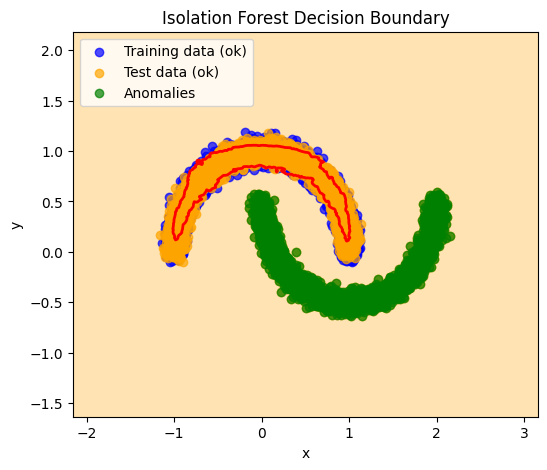

In [11]:
import numpy as np
from models.isolation_forest_model import IsolationForestModel
import matplotlib.pyplot as plt

# Instantiate the model
iso_forest = IsolationForestModel(
    n_estimators=100,
    max_samples='auto',
    contamination=0.2,
    random_state=42
)

# Fit on training data
iso_forest.fit(X_train)

# Predict on test data
y_pred = iso_forest.predict(X_test)

# Evaluate
metrics = iso_forest.evaluate(X_test, test_ground_truth)
print("Isolation Forest Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# Suppose you have X_train, X_test, and test_ground_truth defined.
# And you have already trained your model and obtained predictions.

# Determine outlier indices based on ground truth, if desired:
outlier_mask = (test_ground_truth == -1)

# Call the plotting method on your best model (or an instance of IsolationForestModel)
iso_forest.plot_decision_boundary(X_train, X_test=X_test, X_outliers=X_test[outlier_mask])
